# Load Datasets

In [7]:
import os
os.chdir('/Users/yinancheng/Documents/Project/TrustworthyAI/Advertisement/')

import pandas as pd
task_id = 18800
path = f'Data/potential_{task_id}'
label = 'label_x'

result_path = f'Result/potential_{task_id}'
if not os.path.exists(result_path):
    os.makedirs(result_path)

In [14]:
df_train = pd.read_csv(f'{path}/df_train.csv')
df_syn_ctgan = pd.read_csv(f'{path}/df_syn_ctgan.csv')
df_syn_ctabgan = pd.read_csv(f'{path}/df_syn_ctabgan.csv')
df_syn_tvae = pd.read_csv(f'{path}/df_syn_tvae.csv')
df_syn_ds = pd.read_csv(f'{path}/df_syn_ds.csv')
#df_syn_great = pd.read_csv(f'{path}/df_syn_great.csv')
df_syn_tabula = pd.read_csv(f'{path}/df_syn_tabula.csv')
#df_syn_tabula[label] = df_syn_tabula[label].astype("int64")
#df_syn_tabddpm = pd.read_csv(f'{path}/df_syn_tabddpm.csv')
df_holdout = pd.read_csv(f'{path}/df_holdout.csv')
df_val = pd.read_csv(f'{path}/df_val.csv')
print("data is loaded...")

data is loaded...


In [20]:
print(df_train[label].unique())
print(df_syn_ctgan[label].unique())
print(df_syn_ctabgan[label].unique())
print(df_syn_tvae[label].unique())
print(df_syn_ds[label].unique())
#print(df_syn_great.unique())
print(df_syn_tabula[label].unique())
#print(df_syn_tabddpm.unique())
print(df_holdout[label].unique())
print(df_val[label].unique())

[1 0]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]


In [13]:
from Dataset_Utility import utility_functions as uf
uf.calculate_label_rate2(df_train, label)
uf.calculate_label_rate2(df_syn_ctgan, label)
uf.calculate_label_rate2(df_syn_ctabgan, label)
uf.calculate_label_rate2(df_syn_tvae, label)
uf.calculate_label_rate2(df_syn_ds, label)
#uf.calculate_label_rate2(df_syn_great, label)
uf.calculate_label_rate2(df_syn_tabula, label)
#uf.calculate_label_rate2(df_syn_tabddpm, label)
uf.calculate_label_rate2(df_holdout, label)
uf.calculate_label_rate2(df_val, label)

Total Sample size is 4936, Positive Sample size is 128, Negative Sample size is 4808, label rate is 0.026622296173044926
Total Sample size is 4936, Positive Sample size is 188, Negative Sample size is 4748, label rate is 0.039595619208087615
Total Sample size is 4936, Positive Sample size is 180, Negative Sample size is 4756, label rate is 0.03784693019343986
Total Sample size is 4936, Positive Sample size is 15, Negative Sample size is 4921, label rate is 0.003048160942897785
Total Sample size is 4936, Positive Sample size is 112, Negative Sample size is 4824, label rate is 0.02321724709784411
Total Sample size is 4936, Positive Sample size is 135, Negative Sample size is 4801, label rate is 0.028119141845448864
Total Sample size is 4936, Positive Sample size is 128, Negative Sample size is 4808, label rate is 0.026622296173044926
Total Sample size is 2468, Positive Sample size is 64, Negative Sample size is 2404, label rate is 0.026622296173044926


# 1. Train Classifier and Evaluate

In [7]:
#!pip install pygam
#!pip install xgboost
#!pip install git+https://github.com/lemeln/nam

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from pygam import LogisticGAM
from xgboost import XGBClassifier
from nam.wrapper import NAMClassifier

# Dictionary of models
models = {
    'LR': LogisticRegression(),
    'DT': DecisionTreeClassifier(random_state=0),
    'KNN': KNeighborsClassifier(),
    'NB': GaussianNB(),
    'SVM': SVC(random_state=0, probability=True),
    'RF': RandomForestClassifier(random_state=0),    
    #'GAM': LogisticGAM(), # Does not converge
    'XGB': XGBClassifier()#,
    #'NAM': NAMClassifier()
}

# Dictionary of samples
samples = {
    'Training': df_train,
    'Holdout': df_holdout,
    'CTGAN': df_syn_ctgan,
    'CTABGAN': df_syn_ctabgan,
    'TVAE': df_syn_tvae,
    'DS': df_syn_ds,
    #'GReaT': df_syn_great,
    'Tabula': df_syn_tabula,
    #'TabDDPM': df_syn_tabddpm
}

In [21]:
# Use the following loop, we can get sets of predictors and sets of response of each sample
# For example, X_CTGAN is the set of predictors for the df_syn_ctgan sample
for name, sample in samples.items():
    globals()[f'X_{name}'] = sample.drop(label, axis=1) # Predictors
    globals()[f'y_{name}'] = sample[label] # Response

X_val = df_val.drop(label, axis=1) # Predictors of valide
y_val = df_val[label] # Response of valid

In [22]:
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.metrics import average_precision_score, precision_recall_curve, roc_curve, auc
from sklearn.metrics import f1_score,recall_score, precision_score

# Create a dataframe to save the result
sample_model = []
for sample in samples.keys():
    for model in models.keys():
        sample_model.append(f'{sample}_{model}')        
columns=['Accuracy', 'AUC', 'F1', 'Recall','Precision', 'AP','TPR', 'FPR', 'TNR', 'FNR']
result = pd.DataFrame(index = sample_model, columns=columns)

def model_evaluation(name, model, sample, X_train, y_train, X_val, y_val):
    # Standardize training set and valid set 
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    # Fit model
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    # Predict probabilities
    if ind == 1:
        y_proba = model.predict_proba(X_val) # When the model is GAM or NAM
    else:
        y_proba = model.predict_proba(X_val)[:,1] # Otherwise
    
    # Metric 1: accuracy
    accuracy = accuracy_score(y_val, y_pred)
    # Metric 2: ROC AUC
    auroc = roc_auc_score(y_val, y_proba)
    # Metric 3: F1 score
    f1 = f1_score(y_val, y_pred)
    # Metric 4: recall score
    recall = recall_score(y_val, y_pred) 
    # Metric 5: precision score
    precision = precision_score(y_val, y_pred)  
    # Metric 6: average_precision    
    ap = average_precision_score(y_val, y_proba)
    # Metric 7: confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()
    tpr = tp / (tp + fn)  
    fpr = fp / (fp + tn)  
    tnr = tn / (tn + fp)  
    fnr = fn / (tp + fn)
    
    result.loc[f'{sample}_{name}'] = [
        round(accuracy, 3), round(auroc, 3), round(f1, 3), round(recall, 3), round(precision, 3), round(ap, 3),
        round(tpr, 3), round(fpr, 3), round(tnr, 3), round(fnr, 3)
    ]
    
    # For figures
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_val, y_proba)
    roc_auc = auc(fpr, tpr)

    globals()[f'{sample}_{name}_fpr'] = fpr
    globals()[f'{sample}_{name}_tpr'] = tpr
    globals()[f'{sample}_{name}_auc'] = roc_auc
    
    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_val, y_proba)
    ap = average_precision_score(y_val, y_proba)
    globals()[f'{sample}_{name}_precision'] = precision
    globals()[f'{sample}_{name}_recall'] = recall
    globals()[f'{sample}_{name}_ap'] = ap
    
    #print(sample + " "+ name +" done")

***There are warnings showing results have value 0 for some precisions.***

In [23]:
for sample in samples.keys():
    X_train = globals()[f'X_{sample}']
    y_train = globals()[f'y_{sample}']
    for name, model in models.items():
        if name == "GAM" or name == "NAM":
            ind = 1
        else:
            ind = 0
        model_evaluation(name, model, sample, X_train, y_train, X_val, y_val)

result.to_csv(f"{path}/result.csv", index = True)
result.to_csv(f"{result_path}/result.csv", index = True)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

# 2. Evaluation Result

In [9]:
import pandas as pd

result = pd.read_csv(f'{path}/result.csv').set_index('Unnamed: 0')
result

,Accuracy,AUC,F1,Recall,Precision,AP,TPR,FPR,TNR,FNR
Unnamed: 0,,,,,,,,,,
Training_LR,0.974,0.658,0.000,0.000,0.000,0.062,0.000,0.000,1.000,1.000
Training_DT,0.953,0.546,0.080,0.078,0.082,0.033,0.078,0.023,0.977,0.922
Training_KNN,0.973,0.578,0.000,0.000,0.000,0.040,0.000,0.001,0.999,1.000
Training_NB,0.071,0.671,0.051,0.969,0.026,0.050,0.969,0.953,0.047,0.031
Training_SVM,0.974,0.627,0.000,0.000,0.000,0.069,0.000,0.000,1.000,1.000
Training_RF,0.972,0.667,0.104,0.062,0.308,0.086,0.062,0.004,0.996,0.938
Training_XGB,0.971,0.671,0.100,0.062,0.250,0.085,0.062,0.005,0.995,0.938
Holdout_LR,0.974,0.638,0.000,0.000,0.000,0.065,0.000,0.000,1.000,1.000
Holdout_DT,0.951,0.561,0.116,0.125,0.108,0.039,0.125,0.027,0.973,0.875


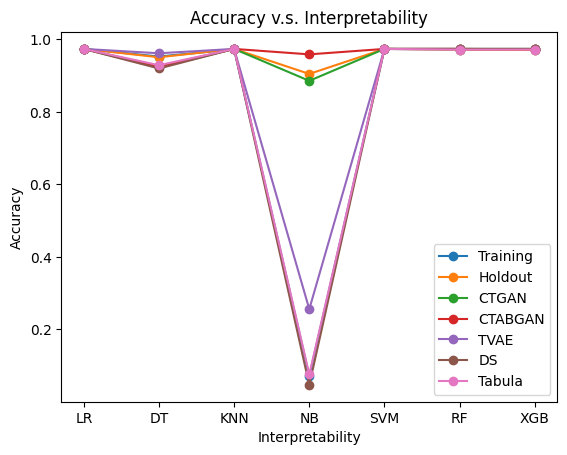

In [16]:
import matplotlib.pyplot as plt

# Plot of Accuracy
for sample in samples.keys():
    Accuracy = []
    for model in models.keys():
        Accuracy.append(result.loc[f'{sample}_{model}']["Accuracy"])
    plt.plot(models.keys(), Accuracy , 'o-', label=f'{sample}')
plt.xlabel('Interpretability')
plt.ylabel('Accuracy')
plt.legend(loc="lower right")
plt.title('Accuracy v.s. Interpretability')
plt.show()

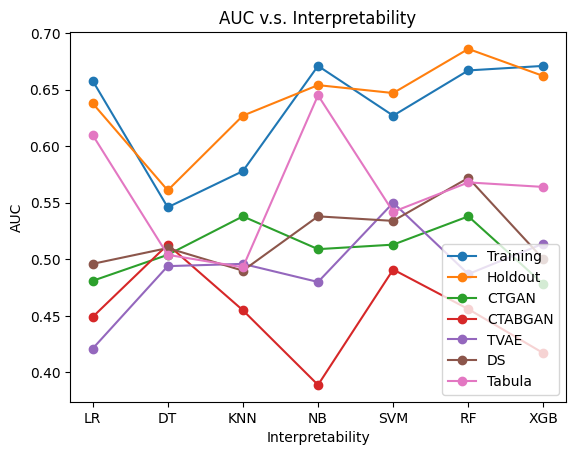

In [17]:
# Plot of AUC

for sample in samples.keys():
    AUC = []
    for model in models.keys():
        AUC.append(result.loc[f'{sample}_{model}']["AUC"])
    plt.plot(models.keys(), AUC , 'o-', label=f'{sample}')
plt.xlabel('Interpretability')
plt.ylabel('AUC')
plt.legend(loc="lower right")
plt.title('AUC v.s. Interpretability')
plt.show()

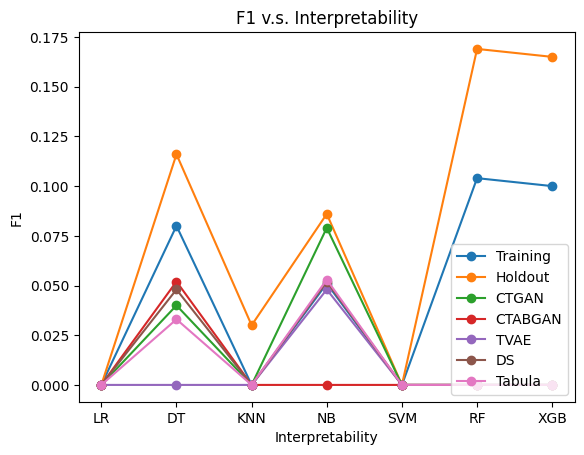

In [18]:
# Plot of F1

for sample in samples.keys():
    F1 = []
    for model in models.keys():
        F1.append(result.loc[f'{sample}_{model}']["F1"])
    plt.plot(models.keys(), F1 , 'o-', label=f'{sample}')
plt.xlabel('Interpretability')
plt.ylabel('F1')
plt.legend(loc="lower right")
plt.title('F1 v.s. Interpretability')
plt.show()

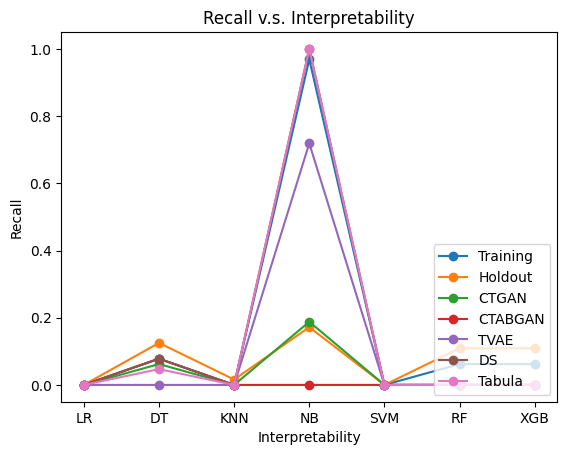

In [19]:
# Plot of Recall

for sample in samples.keys():
    Recall = []
    for model in models.keys():
        Recall.append(result.loc[f'{sample}_{model}']["Recall"])
    plt.plot(models.keys(), Recall , 'o-', label=f'{sample}')
plt.xlabel('Interpretability')
plt.ylabel('Recall')
plt.legend(loc="lower right")
plt.title('Recall v.s. Interpretability')
plt.show()

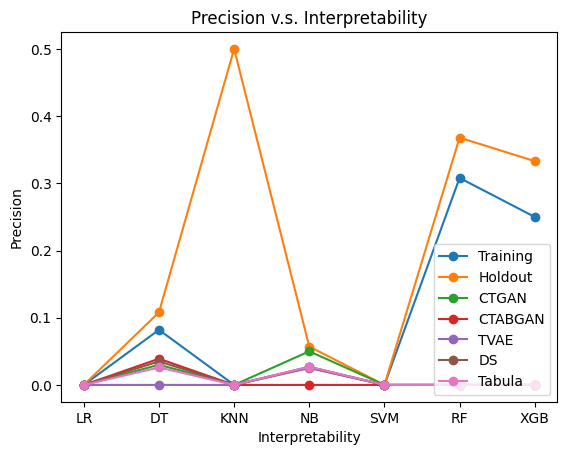

In [20]:
# Plot of Precision

for sample in samples.keys():
    Precision = []
    for model in models.keys():
        Precision.append(result.loc[f'{sample}_{model}']["Precision"])
    plt.plot(models.keys(), Precision, 'o-', label=f'{sample}')
plt.xlabel('Interpretability')
plt.ylabel('Precision')
plt.legend(loc="lower right")
plt.title('Precision v.s. Interpretability')
plt.show()

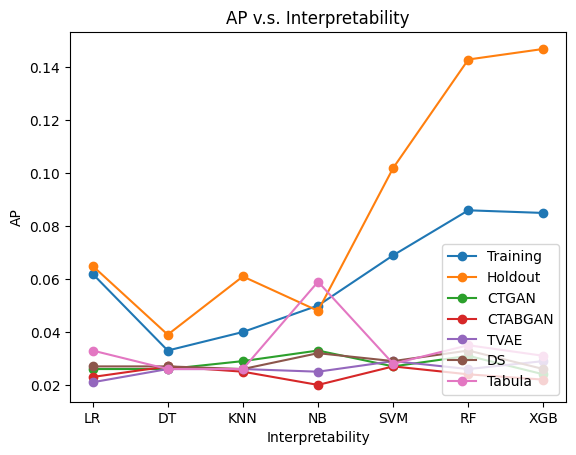

In [21]:
# Plot of AP

for sample in samples.keys():
    AP = []
    for model in models.keys():
        AP.append(result.loc[f'{sample}_{model}']["AP"])
    plt.plot(models.keys(), AP, 'o-', label=f'{sample}')
plt.xlabel('Interpretability')
plt.ylabel('AP')
plt.legend(loc="lower right")
plt.title('AP v.s. Interpretability')
plt.show()

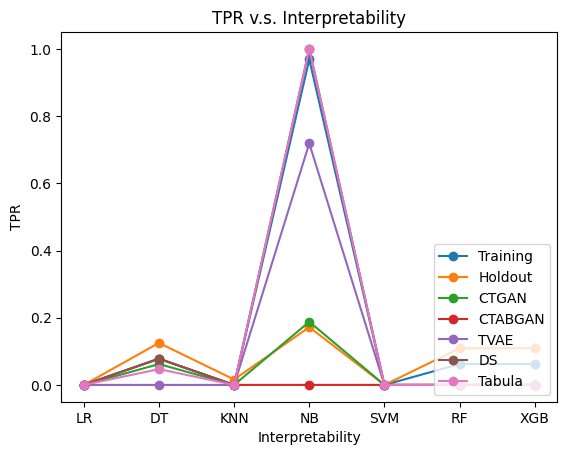

In [22]:
# Plot of TPR

for sample in samples.keys():
    TPR = []
    for model in models.keys():
        TPR.append(result.loc[f'{sample}_{model}']["TPR"])
    plt.plot(models.keys(), TPR, 'o-', label=f'{sample}')
plt.xlabel('Interpretability')
plt.ylabel('TPR')
plt.legend(loc="lower right")
plt.title('TPR v.s. Interpretability')
plt.show()

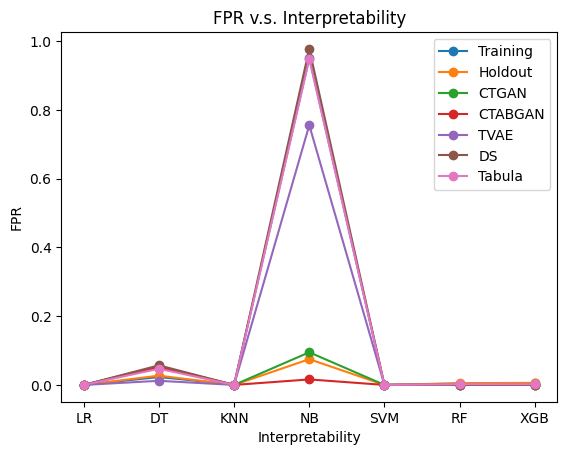

In [23]:
# Plot of FPR

for sample in samples.keys():
    FPR = []
    for model in models.keys():
        FPR.append(result.loc[f'{sample}_{model}']["FPR"])
    plt.plot(models.keys(), FPR, 'o-', label=f'{sample}')
plt.xlabel('Interpretability')
plt.ylabel('FPR')
plt.legend(loc="best")
plt.title('FPR v.s. Interpretability')
plt.show()

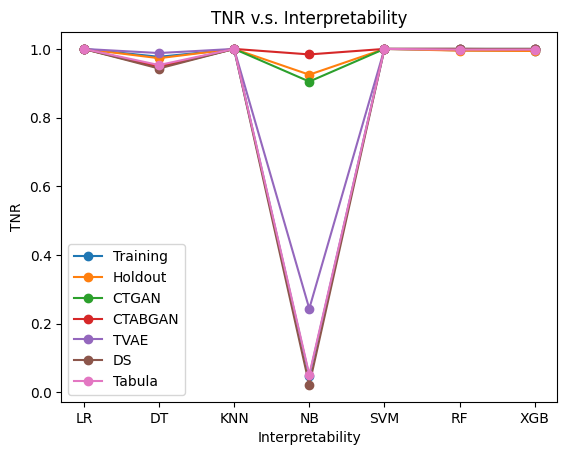

In [24]:
# Plot of TNR

for sample in samples.keys():
    TNR = []
    for model in models.keys():
        TNR.append(result.loc[f'{sample}_{model}']["TNR"])
    plt.plot(models.keys(), TNR, 'o-', label=f'{sample}')
plt.xlabel('Interpretability')
plt.ylabel('TNR')
plt.legend(loc="best")
plt.title('TNR v.s. Interpretability')
plt.show()

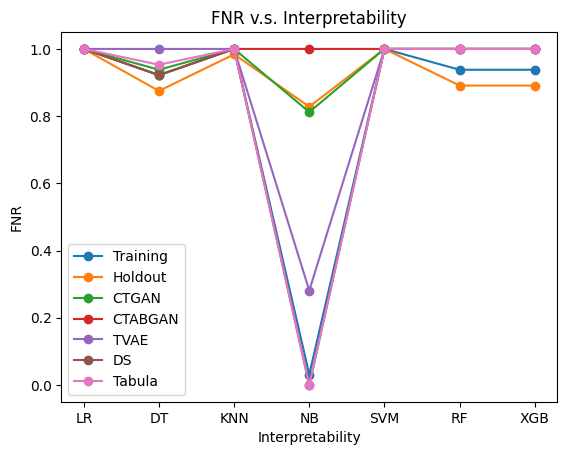

In [25]:
# Plot of FNR

for sample in samples.keys():
    FNR = []
    for model in models.keys():
        FNR.append(result.loc[f'{sample}_{model}']["FNR"])
    plt.plot(models.keys(), FNR, 'o-', label=f'{sample}')
plt.xlabel('Interpretability')
plt.ylabel('FNR')
plt.legend(loc="best")
plt.title('FNR v.s. Interpretability')
plt.show()